# Demultiplexing - Part 1

### 0 - Prelims

Made mini test files using (or equiv for each file)

    zcat 294_S1_L008_R1_001.fastq.gz | head -400 > /programs/bgmp/cbrewste/demult/R1.fastq

then tested to see which was which using

    cat R*.fastq | head -2
   
and checked read length with

    cat R*.fastq | head -2 | tail -1 | wc -c

...and then subtracted 1 for newlines.

Anna went ahead and did

    zcat 1294*R1* | wc -l
    
and got 1452986940 for each, meaning 363246735 reads per file.
    
### 1 - File identities 

| file | content | read length |
|---|---|---|
| 1294_S1_L008_R1_001.fastq.gz | read 1 | 101 |
| 1294_S1_L008_R2_001.fastq.gz | index 1 | 8 |
| 1294_S1_L008_R3_001.fastq.gz | index 2 | 8 |
| 1294_S1_L008_R4_001.fastq.gz | read 2 | 101 |

### 2 - Quality distributions

Here's the gist of the code:

In [27]:
import numpy as np
import math
import gzip

def convert_phred(letter):
    """ Converts a single character into a phred-33 score """
    return (int(ord(letter)-33)) #I love you, ord

def init_ndarray(x):
    """ initialize desired size of ndarray and return """
    return(np.zeros(shape=(x), dtype=int))

def get_means(file,reads,readlen,title):
    """ given gzip file, # of reads, and lenght of reads return 2darray of scores """
    i=0
    scores=init_ndarray(readlen)
    with gzip.open(file, 'rt') as f:
        for line in f:
            if i%4==3:
                for j in range(readlen):
                    scores[j]+=convert_phred(line[j])
            for k in range(readlen):
                scores[k]=scores[k]
            i+=1
    out=open('/projects/bgmp/cbrewste/demult/'+title.replace(" ","_")+'.txt','+w')
    #out=open(title+'.txt','+w')
    for m in scores:
        out.write("{},".format(m/reads))
        print(m/reads)
    return(True)

And a sample SLURM batch file:

    #!/bin/bash
    #SBATCH --partition=short
    #SBATCH --job-name=QD1
    #SBATCH --time=0-12:00:00
    #SBATCH --nodes=1
    #SBATCH --ntasks-per-node=20
    module purge
    module load prl
    module load python/3.6.0
    /usr/bin/time -v python3 QD1.py
   
I initially was tryting to run all four data processing and plotting functions in one... that was a bad idea. I separated all of the input files in to separate jobs, submitted to Talapas individually, and had them output a comma-separated txt file of means. I'll download the results and plot them locally.

I finally got my SLURM scripts to run sucessfully, so now let's plot some data!

True

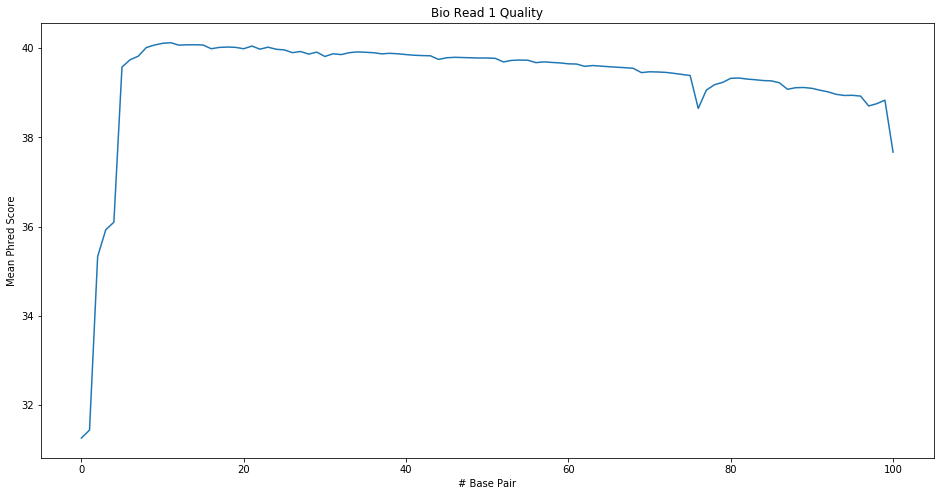

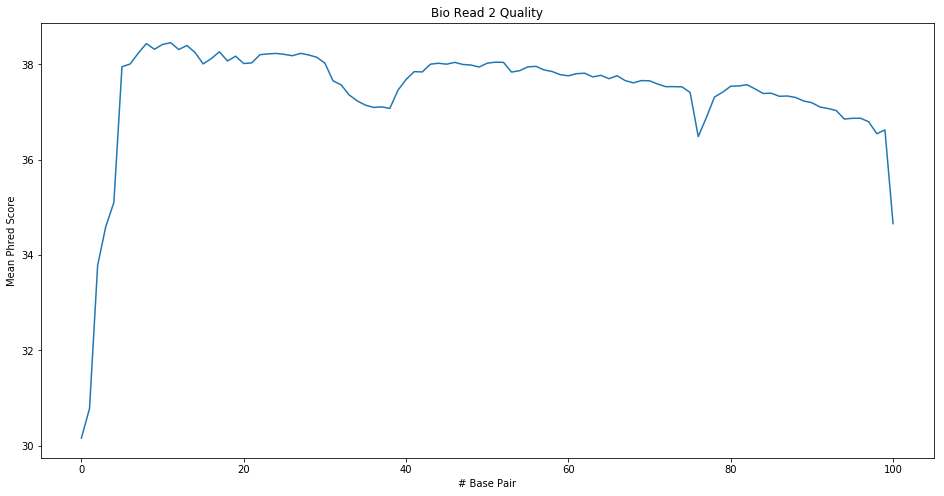

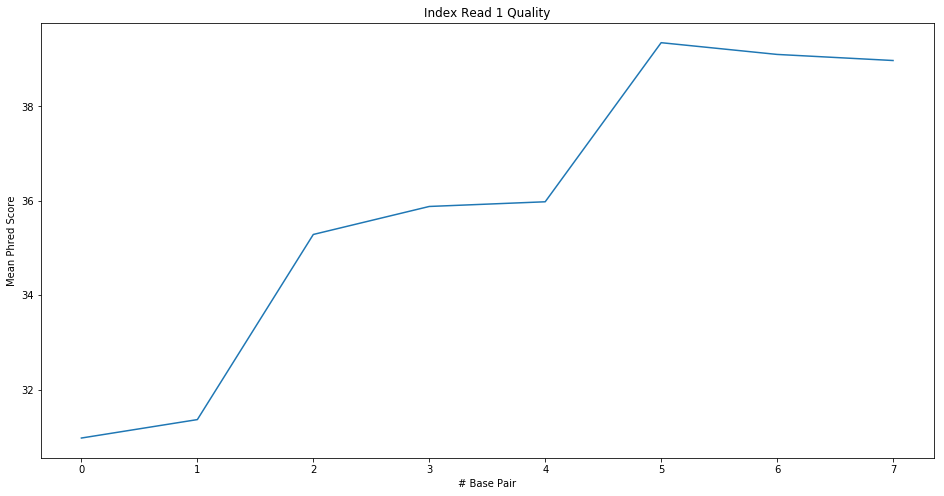

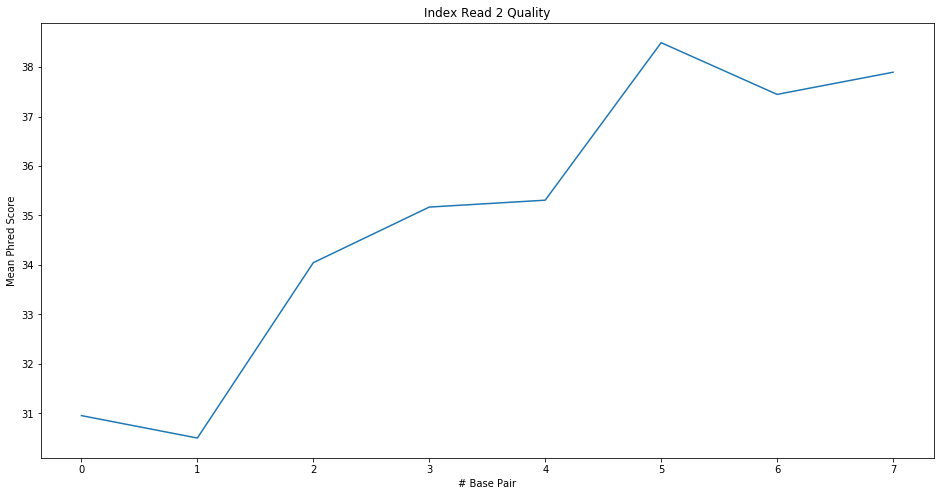

In [25]:
import numpy as np
import math
import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt

def arrayify(file):
    """ given a comma-separated file, return it as an array """
    r=[]
    for i in open(file).read().split(","):
        if len(i)>1:
            r.append(float(i))
    return(r)
    
def plot_dist(f,t,l):
    """ given file of means (m), a title (t), and read length (l), plot it + write PDF """
    means=arrayify(f)
    x=range(l)
    y=range(40)
    fig=plt.figure(figsize=(16,8))
    ax1=fig.add_subplot(111)
    ax1.plot(means)
    plt.title(t)
    plt.ylabel("Mean Phred Score")
    plt.xlabel("# Base Pair")
    #plt.show()
    fig.savefig(t.replace(" ","_")+".pdf")
    return(True)

plot_dist("Bio_Read_1_Quality.txt","Bio Read 1 Quality",101)
plot_dist("Bio_Read_2_Quality.txt","Bio Read 2 Quality",101)
plot_dist("Index_Read_1_Quality.txt","Index Read 1 Quality",8)
plot_dist("Index_Read_2_Quality.txt","Index Read 2 Quality",8)

**NOTE:** The python scripts and PDFs of plots are also in the repository.

### 2b - Index quality cutoffs

According to [this 2016 paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5097354/),* using 26 as the lower threshold for mean index quality scores works pretty well for single-index reads, preserving ~90% of reads. I would think that paired-index reads would allow more reads to be conserved, as crappy-quality index reads could be compared to each other to increase confidence in the correct index. Being stricter with index quality helps prevent cross-talk, but also means we lose more reads, so it's a tradeoff.

### 2c - Indices with "N" calls
I used the command:

    zcat 1294_S1_L008_R3_001.fastq.gz | sed -n '2~4p' | grep N | wc -l
    
and found that the read 1 file had 3976613 indices with "N" and the read 2 file had 3328051, for a total of 7304664.